# Data analysis 
Data split, model creation (logistic regression, random forest and Z''-score) & model validation

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report,
                            precision_recall_curve, plot_precision_recall_curve, roc_auc_score

In [13]:
# ***** LOAD DATAFRAME: df2 *****

path = "C:/Users/Aleksi/ownCloud/Vaasan Yliopisto/Gradu/Python codes/FIN/New_Version/"
df2 = pd.read_csv(filepath_or_buffer=path+'df2.txt', index_col=0)

b = df2['status']==1 # mask for bankrupt
h = df2['status']==0 # mask for healthy/active

print('Bankrupt firms:',round((b.sum()/len(df2))*100,2),'%',
      'Healthy firms:',100-round((b.sum()/len(df2))*100,2),'%','\n',
      'Shape:', df2.shape)

Bankrupt firms: 2.68 % Healthy firms: 97.32 % 
 Shape: (96995, 28)


### Data Split

In [14]:
# REDUCE THE PROPORTION OF HEALTHY FIRMS (OPTIONAL!)

np.random.seed(10)
rows = np.random.randint(0,h.sum()-1,len(df2[b])) # choose random rows (start,last, n instances)
healthy = df2[h] # df of  healthy firms
healthy = healthy.iloc[rows,:] # pick random rows
df3 = healthy.append(df2[b], ignore_index=True) # join together
df3.shape

(5190, 28)

In [15]:
# ***** SPLIT INTO TRAINING AND VALIDATION SETS *****

# firm-specific:      X1 X2 X3 X4
# macro economic:     GDP change %, Household debt %, Household interest %, M3


# variables to choose for round
t_0 = ['X1','X2','X3','X4','GDP change %','Household interest %','Household debt %']


# X (predictor matrix), y (label vector)
X = df3.loc[:,t_0]
X_Z = df3.loc[:,['X1','X2','X3','X4']] # for Z''-score
y = df3.loc[:,'status']



# TRAINING AND VALIDATION SET

split_ratio = 0.2    # percentage of data used for validation


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_ratio, random_state=2)
X_train_Z, X_val_Z, y_train_Z, y_val_Z = train_test_split(X_Z, y, test_size=split_ratio, random_state=2)

# STANDARDIZE FEATURES for other than Z-''score model: not used!

#scaler = preprocessing.StandardScaler()
#X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
#X_val = pd.DataFrame(scaler.fit_transform(X_val),columns=X_val.columns)


subsets = pd.DataFrame(data=[X_train.shape, X_val.shape, y_train.shape, y_val.shape], 
                       index=['X_train','X_val','y_train','y_val'],
                       columns=['rows','columns'])
print('Split ratio',split_ratio,2*'\n',subsets)


Split ratio 0.2 

          rows  columns
X_train  4152      7.0
X_val    1038      7.0
y_train  4152      NaN
y_val    1038      NaN


###  Logistic Regression

In [16]:
logreg = LogisticRegression(C=1, random_state=0, fit_intercept=True, max_iter=600) # create LogReg object
logreg.fit(X_train,y_train)                                                     # train the model
logreg_pred = logreg.predict(X_val)                                             # predict validation
logreg_conf = logreg.decision_function(X_val)                                   # confidence of classification
logreg_fpr, logreg_tpr, threshold_logreg = roc_curve(y_val, logreg_conf)        # ROC


### Random Forest

In [17]:
r_forest = RandomForestClassifier(n_estimators=100)                              # create RandomForest object
r_forest.fit(X_train,y_train)                                                   # train the model
r_forest_pred = r_forest.predict(X_val)                                         # predict validation
r_forest_conf = r_forest.predict_proba(X_val)                                   # confidence of classification
r_forest_fpr, r_forest_tpr, threshold_rf = roc_curve(y_val, r_forest_conf[:,1]) # ROC

### Original Z''-score 

In [18]:
# Calculate the original Z''-score value from validation set: Note that no training involved!
z = 3.25+ \
    6.56*X_val_Z.iloc[:,0]+ \
    3.26*X_val_Z.iloc[:,1]+ \
    6.72*X_val_Z.iloc[:,2]+ \
    1.05*X_val_Z.iloc[:,3]           # Pandas Series object


# CREATE A ROC CURVE WITH DIFFERENT TRESHOLDS: original treshold: 0 if Z > 2.6, 1 otherwise

n_treshold = 500 # number of steps in treshold
lin_vals =  np.linspace(-5,15,n_treshold)
z_fpr_tpr = np.array([])

# iterate with different tresholds and store each fpr & tpr
for t in np.nditer(lin_vals):

    z_pred = np.array([int(1) if i <= float(t) else int(0) for i in z])
    z_fpr, z_tpr, threshold_z = roc_curve(y_val_Z, z_pred)
    z_fpr_tpr = np.append(z_fpr_tpr, np.array([z_fpr[1],z_tpr[1]]), axis=0)

z_fpr_tpr = z_fpr_tpr.reshape((n_treshold,2))
z_fpr_tpr[0,:] = [0,0]  # first value: AUC purpose, force to be 0,0
z_fpr_tpr[-1,:] = [1,1] # last value: for AUC purpose, force to be 1,1
z_pred = np.array([int(1) if i <= 2.6 else int(0) for i in z]) # save the original treshold value 2.6 for report



### Re-estimation of Z''-score? (Linear & Quadratic Discriminant Analysis)

In [19]:
# ***** LINEAR DISCRIMINANT ANALYSIS *****

lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)
lda_pred = lda.predict(X_val)

lda_conf = lda.decision_function(X_val) # confidence of classification
lda_fpr, lda_tpr, threshold_lda = roc_curve(y_val, lda_conf)



# ***** QUADRATIC DISCRIMINANT ANALYSIS *****

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train,y_train)
qda_pred = qda.predict(X_val)

qda_conf = qda.decision_function(X_val) # confidence of classification
qda_fpr, qda_tpr, threshold_qda = roc_curve(y_val, qda_conf)


### Plot AUC

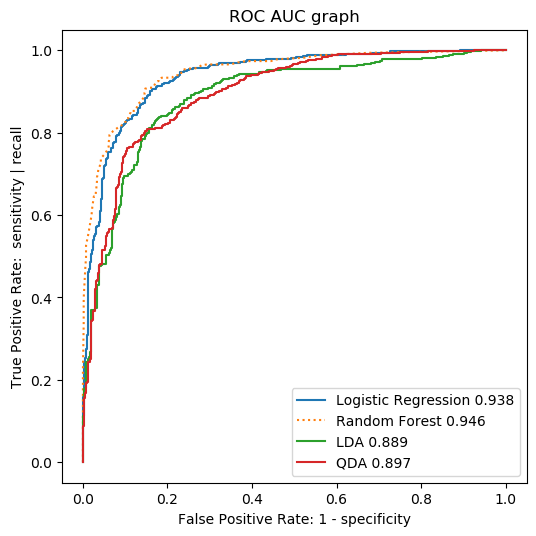

In [20]:
#  Generally, finding as many bankrupt firms as possible is more essential than for non-bankrupt.
#  Thus, true positive rate (sensitivity) is a key metrics  in this thesis


# ***** AUC GRAPH *****

plt.figure(figsize=(6,6),dpi=100)

plt.plot(logreg_fpr,logreg_tpr, linestyle='-', label='Logistic Regression %0.3f'% auc(logreg_fpr,logreg_tpr))
plt.plot(r_forest_fpr, r_forest_tpr, linestyle=':', label='Random Forest %0.3f'% auc(r_forest_fpr, r_forest_tpr))
#plt.plot(z_fpr_tpr[:,0], z_fpr_tpr[:,1], linestyle='-', label="Z''-score %0.3f" ...
# % auc(z_fpr_tpr[:,0], z_fpr_tpr[:,1]))
plt.plot(lda_fpr, lda_tpr, linestyle='-', label='LDA %0.3f'% auc(lda_fpr, lda_tpr))
plt.plot(qda_fpr, qda_tpr, linestyle='-', label='QDA %0.3f'% auc(qda_fpr, qda_tpr))

plt.xlabel('False Positive Rate: 1 - specificity')
plt.ylabel('True Positive Rate:  sensitivity | recall')
plt.title('ROC AUC graph')
plt.legend()
plt.show()


### Plot Precision-Recall Curve

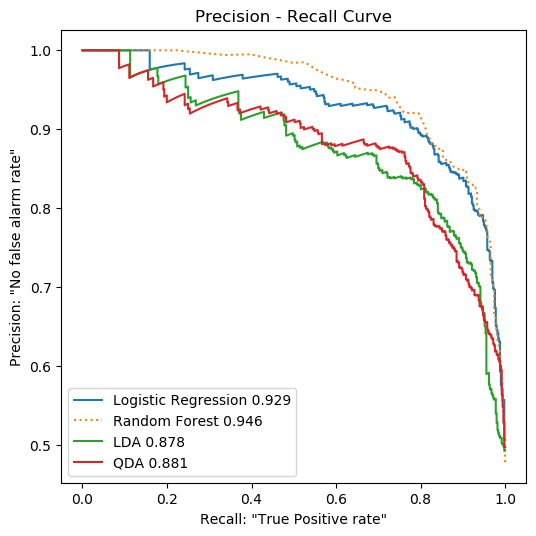

In [21]:
# calculate precision recall curves for the models
precision_log, recall_log, threshold_log = precision_recall_curve(y_val,logreg_conf)
precision_r_forest,recall_r_forest, threshold_r_forest = precision_recall_curve(y_val,r_forest_conf[:,1])
precision_lda,recall_lda, threshold_lda = precision_recall_curve(y_val,lda_conf)
precision_qda,recall_qda, threshold_qda = precision_recall_curve(y_val,qda_conf)

plt.figure(figsize=(6,6),dpi=100)
plt.plot(recall_log, precision_log, linestyle='-', label='Logistic Regression %0.3f'...
         % auc(recall_log, precision_log))
plt.plot(recall_r_forest, precision_r_forest, linestyle=':', label='Random Forest %0.3f'...
         % auc(recall_r_forest, precision_r_forest))
plt.plot(recall_lda, precision_lda, linestyle='-', label='LDA %0.3f'% auc(recall_lda, precision_lda))
plt.plot(recall_qda, precision_qda, linestyle='-', label='QDA %0.3f'% auc(recall_qda, precision_qda))


plt.title('Precision - Recall Curve')
plt.xlabel('Recall: "True Positive rate"')  # true positive rate, real performance
plt.ylabel('Precision: "No false alarm rate"') # "False alerts", costly --> optimise this parameter

plt.legend()
plt.show()



In [22]:
# ***** RECALL, PRECISION AND F1-SCORE *****

models = [logreg, r_forest,lda,qda]

clf_results = pd.DataFrame(columns=['Recall','Precision','F1-score'],
                            index=['Logistic Regression', 'Random Forest', 
                                   'Linear Discriminant Analysis',
                                   'Quadratic Discriminant Analysis'])

for i,model in enumerate(models):
    
    pred = models[i].predict(X_val)
    
    clf_results.iloc[i,0] = round(metrics.recall_score(y_val, pred),3)
    clf_results.iloc[i,1] = round(metrics.precision_score(y_val,pred),3)    
    clf_results.iloc[i,2] = round(metrics.f1_score(y_val,pred),3)


#clf_results.iloc[4,0] = round(metrics.recall_score(y_val, z_pred),3)
#clf_results.iloc[4,1] = round(metrics.precision_score(y_val, z_pred),3)
#clf_results.iloc[4,2] = round(metrics.f1_score(y_val, z_pred),3)


clf_results

,Recall,Precision,F1-score
Logistic Regression,0.819,0.888,0.852
Random Forest,0.889,0.85,0.869
Linear Discriminant Analysis,0.653,0.866,0.745
Quadratic Discriminant Analysis,0.885,0.738,0.805
